In [1]:
# Suppress libpysal FutureWarnings about deprecated Geometry classes
import warnings
warnings.filterwarnings('ignore', category=FutureWarning, module='libpysal')

# Import required libraries
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from libpysal.weights import Queen, Rook, KNN, DistanceBand
from libpysal import examples
import contextily as ctx

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Spatial Weights


"Spatial weights" are one way to represent graphs in geographic data science and spatial statistics. They are widely used constructs that represent geographic relationships between the observational units in a spatially referenced dataset. Implicitly, spatial weights connect objects in a geographic table to one another using the spatial relationships between them. By expressing the notion of geographical proximity or connectedness, spatial weights are the main mechanism through which the spatial relationships in geographical data is brought to bear in the subsequent analysis.

## Introduction

Spatial weights often express our knowledge about spatial relationships. 
For example, proximity and adjacency are common spatial questions: *What neighborhoods are you surrounded by? How many gas stations are within 5 miles of my stalled car?*
These are spatial questions that target specific information about the spatial configuration of a specific target ("a neighborhood," "my stalled car") and geographically connected relevant sites ("adjacent neighborhoods", "nearby gas stations"). For us to use this information in statistical analysis, it's often necessary to compute these relationships between all pairs of observations. This means that, for many applications in geographic data science, we are building a *topology*---a mathematical structure that expresses the connectivity between observations---that we can use to examine the data. Spatial weights matrices express this topology, letting us embed all of our observations in space together, rather than asking and answering single questions about features nearby a unit. 

In [2]:
import contextily
import geopandas
import rioxarray
import seaborn
import pandas
import numpy
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from pysal.lib import cg as geometry

Since they provide a way to represent these spatial relationships, spatial weights are widely used throughout spatial and geographic data science.
In this chapter, we first consider different approaches to construct spatial weights, distinguishing between those based on contiguity/adjacency relations from weights obtained from distance based relationships. We then discuss the case of hybrid weights which combine one or more spatial operations in deriving the neighbor relationships between observations. We illustrate all of these concepts through the spatial weights class in `pysal`, which provides a rich set of methods and characteristics for spatial weights and it is stored under the `weights` sub-module:

In [3]:
from pysal.lib import weights

We also demonstrate its set-theoretic functionality, which permits the derivation of weights through the application of set operations. Throughout the chapter, we discuss common file formats used to store spatial weights of different types, and we include visual discussion of spatial weights, making these sometimes abstract constructs more intuitive.

## Contiguity weights

A contiguous pair of spatial objects are those that share a common border. At first
glance, this seems straightforward. However, in practice this turns out to be
more complicated. The first complication is that there are different ways that objects can "share a common border". Let's start with the example of a three-by-three grid. We can create it as a geo-table from scratch:

In [4]:
# Get points in a grid
l = numpy.arange(3)
xs, ys = numpy.meshgrid(l, l)
# Set up store
polys = []
# Generate polygons
for x, y in zip(xs.flatten(), ys.flatten()):
    poly = Polygon([(x, y), (x + 1, y), (x + 1, y + 1), (x, y + 1)])
    polys.append(poly)
# Convert to GeoSeries
polys = geopandas.GeoSeries(polys)
gdf = geopandas.GeoDataFrame(
    {
        "geometry": polys,
        "id": ["P-%s" % str(i).zfill(2) for i in range(len(polys))],
    }
)

which results in the grid shown in the following figure. 

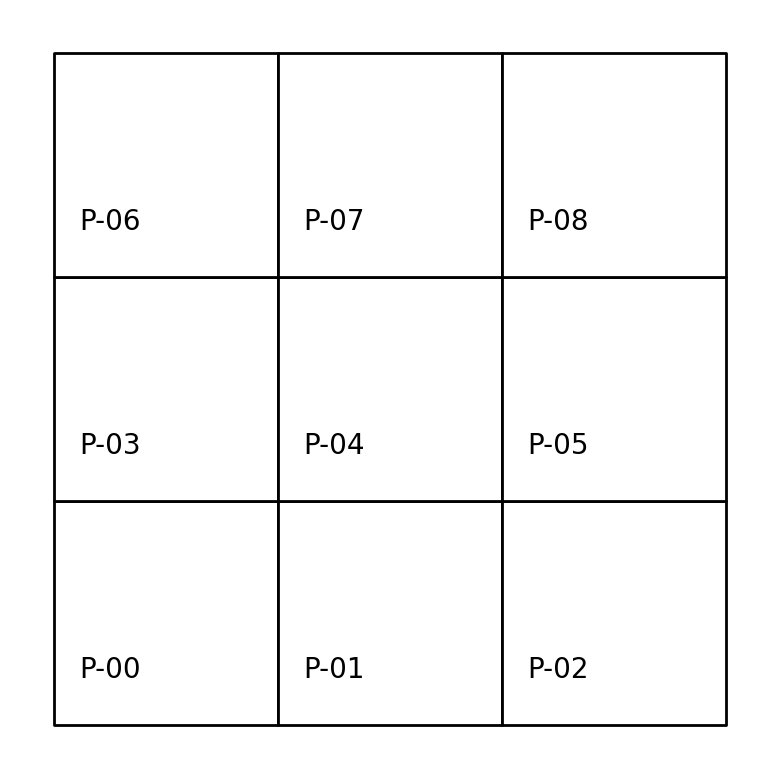

In [5]:
# Plot grid geotable
ax = gdf.plot(facecolor="w", edgecolor="k")

# Loop over each cell and add the text
for x, y, t in zip(
    [p.centroid.x - 0.25 for p in polys],
    [p.centroid.y - 0.25 for p in polys],
    [i for i in gdf["id"]],
):
    plt.text(
        x,
        y,
        t,
        verticalalignment="center",
        horizontalalignment="center",
    )

# Remove axes
ax.set_axis_off()
plt.show()

A common way to express contiguity/adjacency relationships arises from an analogy to the legal moves that different chess pieces can make. *Rook* contiguity requires that the pair of polygons in
question share an *edge*. According to this definition, polygon $0$ would be a Rook neighbor of $1$ and $3$, while $1$ would be a Rook neighbor with $0$, $2$, and $4$. Applying this rule to all nine polygons we can model our neighbor relations as:

In [6]:
# Build a rook contiguity matrix from a regular 3x3
# lattice stored in a geo-table
wr = weights.contiguity.Rook.from_dataframe(gdf)

/var/folders/dy/m471zxc92yg3d_nmckq9dd000000gn/T/ipykernel_58063/3474591331.py:3: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  wr = weights.contiguity.Rook.from_dataframe(gdf)


Note the pattern we use to build the `w` object, which is similar across the library: we specify the criterium we want for the weights (`weights.contiguity.Rook`) and then the "constructor" we will use (`from_dataframe`). We can visualize the result plotted on top of the same grid of labeled polygons, using red dotted lines to represent the edges between a pair of nodes (polygon centroids in this case). We can see this in the following figure. 

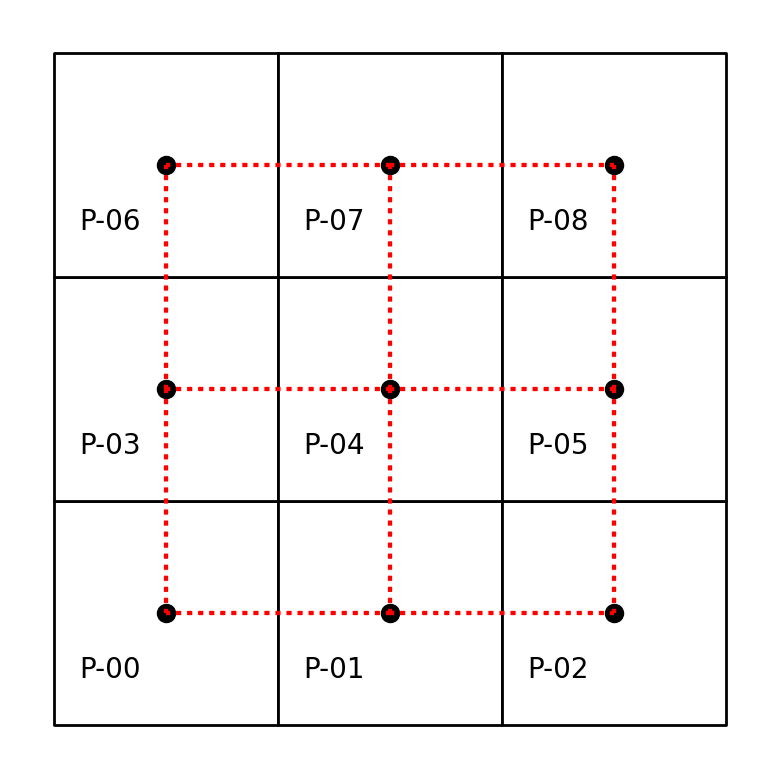

In [7]:
# Set up figure
f, ax = plt.subplots(1, 1, subplot_kw=dict(aspect="equal"))
# Plot grid
gdf.plot(facecolor="w", edgecolor="k", ax=ax)
# Loop over each cell and add the text
for x, y, t in zip(
    [p.centroid.x - 0.25 for p in polys],
    [p.centroid.y - 0.25 for p in polys],
    [i for i in gdf["id"]],
):
    plt.text(
        x,
        y,
        t,
        verticalalignment="center",
        horizontalalignment="center",
    )
# Plot weights connectivity
wr.plot(gdf, edge_kws=dict(color="r", linestyle=":"), ax=ax)
# Remove axes
ax.set_axis_off()

The  `neighbors` attribute of our `pysal` $W$ object encodes the neighbor
relationships by expressing the *focal* observation on the left (in the `key` of the dictionary), and expressing the *neighbors* to the *focal* in the list on the right (in the `value` of the dictionary). This representation has computational advantages, as it exploits
the sparse nature of contiguity weights matrices by recording only non-zero weights:

In [8]:
wr.neighbors

{0: [1, 3],
 1: [0, 2, 4],
 2: [1, 5],
 3: [0, 4, 6],
 4: [1, 3, 5, 7],
 5: [8, 2, 4],
 6: [3, 7],
 7: [8, 4, 6],
 8: [5, 7]}

More specifically, knowing
that the neighbors of polygon $0$ are $3$ and $1$ implies that polygons $2, 4,
5, 6, 7, 8$ are not Rook neighbors of 0. As such, there is no reason to store
the "non-neighbor" information and this results in significant reductions in
memory requirements. However, it is possible to create the fully dense, matrix
representation if needed:

In [9]:
pandas.DataFrame(*wr.full()).astype(int)

,0,1,2,3,4,5,6,7,8
0,0,1,0,1,0,0,0,0,0
1,1,0,1,0,1,0,0,0,0
2,0,1,0,0,0,1,0,0,0
3,1,0,0,0,1,0,1,0,0
4,0,1,0,1,0,1,0,1,0
5,0,0,1,0,1,0,0,0,1
6,0,0,0,1,0,0,0,1,0
7,0,0,0,0,1,0,1,0,1
8,0,0,0,0,0,1,0,1,0


As you can see from the matrix above, most entries are zero. In fact out of all of the possible $9^2=81$ linkages that there could be in this matrix, there are only 24 non-zero entries:

In [10]:
wr.nonzero

24

Thus, we can save a significant amount of memory and lose no information using these sparse representations, which only record the non-zero values. 

More generally, the spatial weights for our 3-by-3 grid can be represented as a matrix that has 9 rows and 9 columns, matching the number of polygons $(n=9)$. An important thing to note is that geography has more than one dimension. When compared to common representations of relationships *in time* used in data science, using information about spatial relationships can be more complex: spatial relationships are bi-directional, while temporal relationships are unidirectional. Further complicating things, the ordering of the observations in the weights matrix is arbitrary. The first row is not first for a specific mathematical reason; it just happens to be the first entry in the input. Here we use the alphanumeric ordering of the unit identifiers to match a polygon with a row or column of the matrix, but any arbitrary rule could be followed and the weights matrix would look different. The graph, however, would be isomorphic and retain the mapping of relationships.

Spatial weights matrices may look familiar to those acquainted with social
networks and graph theory in which **adjacency** matrices play a central role in
expressing connectivity between nodes. Indeed, spatial weights matrices can be
understood as a graph adjacency matrix where each observation is a node and
the spatial weight assigned between a pair represents the weight of the edge on
a graph connecting the arcs. Sometimes, this is called the **dual graph** of the input geographic data. This is advantageous, as geographic data science can
borrow from the rich graph theory literature. At the same time, spatial
data has numerous distinguishing characteristics that necessitate the
development of specialized procedures and concepts in the handling of spatial
weights. This chapter will cover many of these features.

But for now, let's get back to the Rook contiguity graph. A close inspection reveals that this criterion actually places
a restriction on the spatial relation. More specifically, polygons $0$ and $5$
are not Rook neighbors, but they do in fact share a common border. However, in
this instance the sharing is due to a common *vertex* rather than a shared
*edge*. If we wanted them to be considered as neighbours, we can switch to the more inclusive notion of *Queen* contiguity, which
requires the pair of polygons to only share one or more *vertices*. We can create the
neighbor relations for this same configuration as follows:

In [11]:
# Build a queen contiguity matrix from a regular 3x3
# lattice stored in a geo-table
wq = weights.contiguity.Queen.from_dataframe(gdf, use_index="id")
wq.neighbors

{0: [1, 3, 4],
 1: [0, 2, 3, 4, 5],
 2: [1, 4, 5],
 3: [0, 1, 4, 6, 7],
 4: [0, 1, 2, 3, 5, 6, 7, 8],
 5: [1, 2, 4, 7, 8],
 6: [3, 4, 7],
 7: [3, 4, 5, 6, 8],
 8: [4, 5, 7]}

In addition to this neighbors representation, we can also express the graph visually, as done before. This is shown in the following figure.

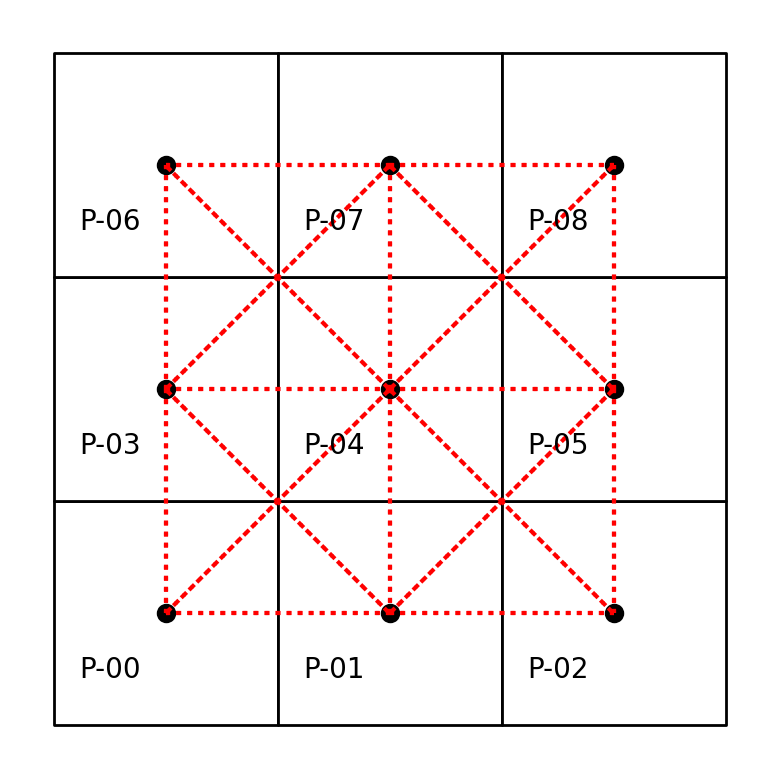

In [12]:
# Set up figure
f, ax = plt.subplots(1, 1, subplot_kw=dict(aspect="equal"))
# Plot grid
gdf.plot(facecolor="w", edgecolor="k", ax=ax)
# Loop over each cell and add the text
for x, y, t in zip(
    [p.centroid.x - 0.25 for p in polys],
    [p.centroid.y - 0.25 for p in polys],
    [i for i in gdf["id"]],
):
    plt.text(
        x,
        y,
        t,
        verticalalignment="center",
        horizontalalignment="center",
    )
# Plot weights connectivity
wq.plot(gdf, edge_kws=dict(color="r", linestyle=":"), ax=ax)
# Remove axes
ax.set_axis_off()

By using `Contiguity.Queen` rather than `Contiguity.Rook`, we consider observations that share a vertex to be neighbors. The result is that the neighbors of $0$ now include $4$ along with $3$ and $1$.

Akin to how the `neighbors` dictionary encodes the contiguity relations, the `weights` dictionary encodes the strength of the link connecting the focal to each neighbor. For contiguity
weights, observations are usually either considered "linked" or "not linked," so the resulting weights matrix is binary. As in any `pysal` `W` object, the actual weight values are contained in the `weights` attribute:

In [13]:
wq.weights

{0: [1.0, 1.0, 1.0],
 1: [1.0, 1.0, 1.0, 1.0, 1.0],
 2: [1.0, 1.0, 1.0],
 3: [1.0, 1.0, 1.0, 1.0, 1.0],
 4: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 5: [1.0, 1.0, 1.0, 1.0, 1.0],
 6: [1.0, 1.0, 1.0],
 7: [1.0, 1.0, 1.0, 1.0, 1.0],
 8: [1.0, 1.0, 1.0]}

Similar to the `neighbors` attribute, the `weights` object is a Python
dictionary that only stores the non-zero weights. Although the weights for a
given observations neighbors are all the same value for contiguity weights, it
is important to note that the `weights` and `neighbors` are aligned with one another; for each observation, its first neighbor in `neighbors` has the first weight in its `weights` entry. This will be important when we examine distance based weights further
on, when observations will have different weights. 

In addition to the `neighbor` and `weights` attributes, the `w` object has a
large number of other attributes and methods that can be useful. The
`cardinalities` attribute reports the number of neighbors for each observation:

In [14]:
wq.cardinalities

{0: 3, 1: 5, 2: 3, 3: 5, 4: 8, 5: 5, 6: 3, 7: 5, 8: 3}

The related `histogram` attribute provides an overview of the distribution of
these cardinalities:

In [15]:
wq.histogram

[(np.int64(3), np.int64(4)),
 (np.int64(4), np.int64(0)),
 (np.int64(5), np.int64(4)),
 (np.int64(6), np.int64(0)),
 (np.int64(7), np.int64(0)),
 (np.int64(8), np.int64(1))]

We can obtain a quick visual representation by converting the cardinalities
into a `pandas.Series` and creating a histogram:

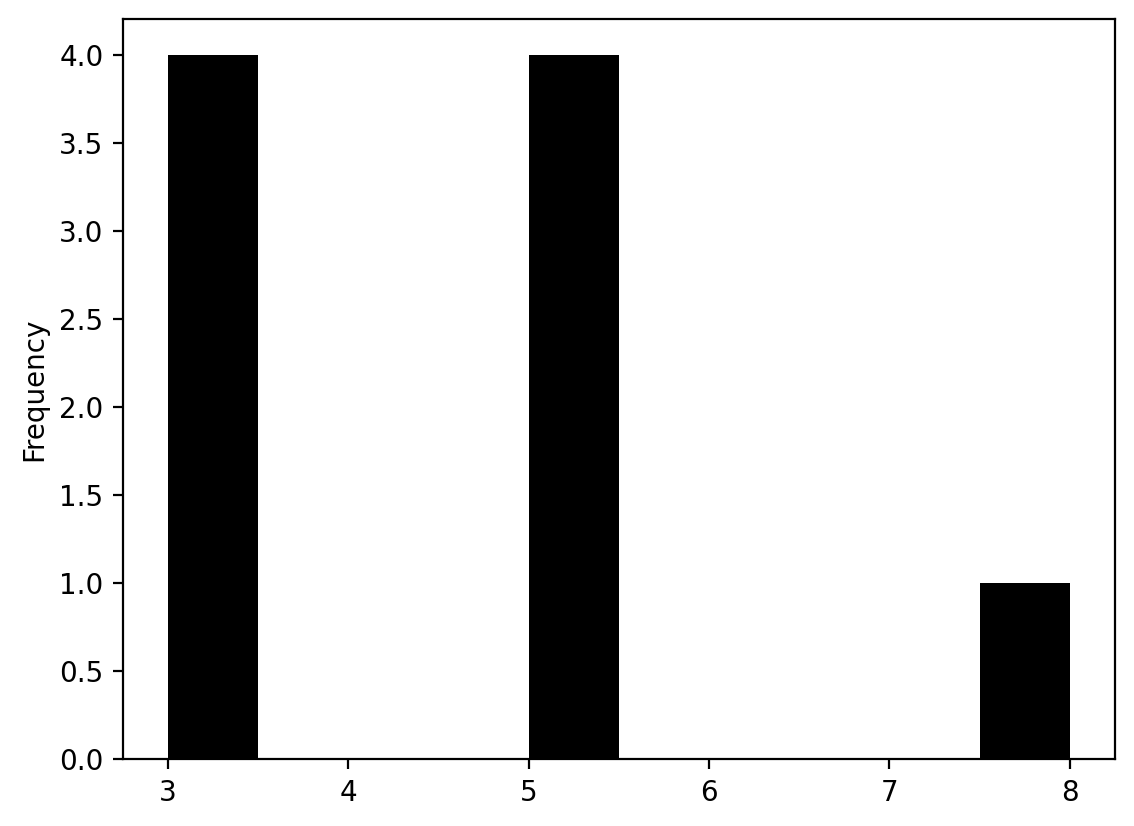

In [16]:
pandas.Series(wq.cardinalities).plot.hist(color="k");

The `cardinalities` and `histogram` attributes help quickly spot asymmetries in
the number of neighbors. This, as we will see later in the book, is relevant
when using spatial weights in other analytical techniques (e.g.,
spatial autocorrelation analysis or spatial regression). Here we see that there are four corner
observations with three neighbors, four edge observations with five neighbors,
and the one central observation has eight neighbors. There are also no
observations with four, six, or seven neighbors.

By convention, an ordered pair of contiguous observations constitutes a *join*
represented by a non-zero weight in a $W$. The attribute `s0` records the number
of joins.

In [17]:
wq.s0

np.float64(40.0)

Thus, the Queen weights here have just under twice the number of joins in this case.
The `pct_nonzero` attribute provides a measure of the density (compliment of
sparsity) of the spatial weights matrix (if we had it stored explicitly, which
we don't):

In [18]:
wq.pct_nonzero

49.382716049382715

which is equal to $100 \times (\texttt{w.s0} / \texttt{w.n}^2)$.

### Spatial weights from real-world geographic tables

The regular lattice map encountered above helps us to understand the logic and
properties of `pysal`'s spatial weights class. However, the artificial nature of
that geography is of limited relevance to real world research problems.
`pysal` supports the construction of spatial weights objects from a
number of commonly used spatial data formats. Here we demonstrate this
functionality for the case of census tracts in San Diego, California. Most spatial
data formats, such as shapefiles, are non-topological in that they encode the
polygons as a collection of vertices defining the edges of the geometry's
boundary. No information about the neighbor relations is explicitly encoded, so we
must construct it ourselves. Under the hood, `pysal` uses efficient spatial indexing
structures to extract these.

In [19]:
san_diego_tracts = geopandas.read_file(
    "data/sandiego/sandiego_tracts.gpkg"
)
w_queen = weights.contiguity.Queen.from_dataframe(san_diego_tracts, use_index=True)

Like before, we can visualize the adjacency relationships, but they are much more difficult to see without showing a closer detail. This higher level of detail is shown in the right pane of the plot.

(<Figure size 800x800 with 1 Axes>, <Axes: >)

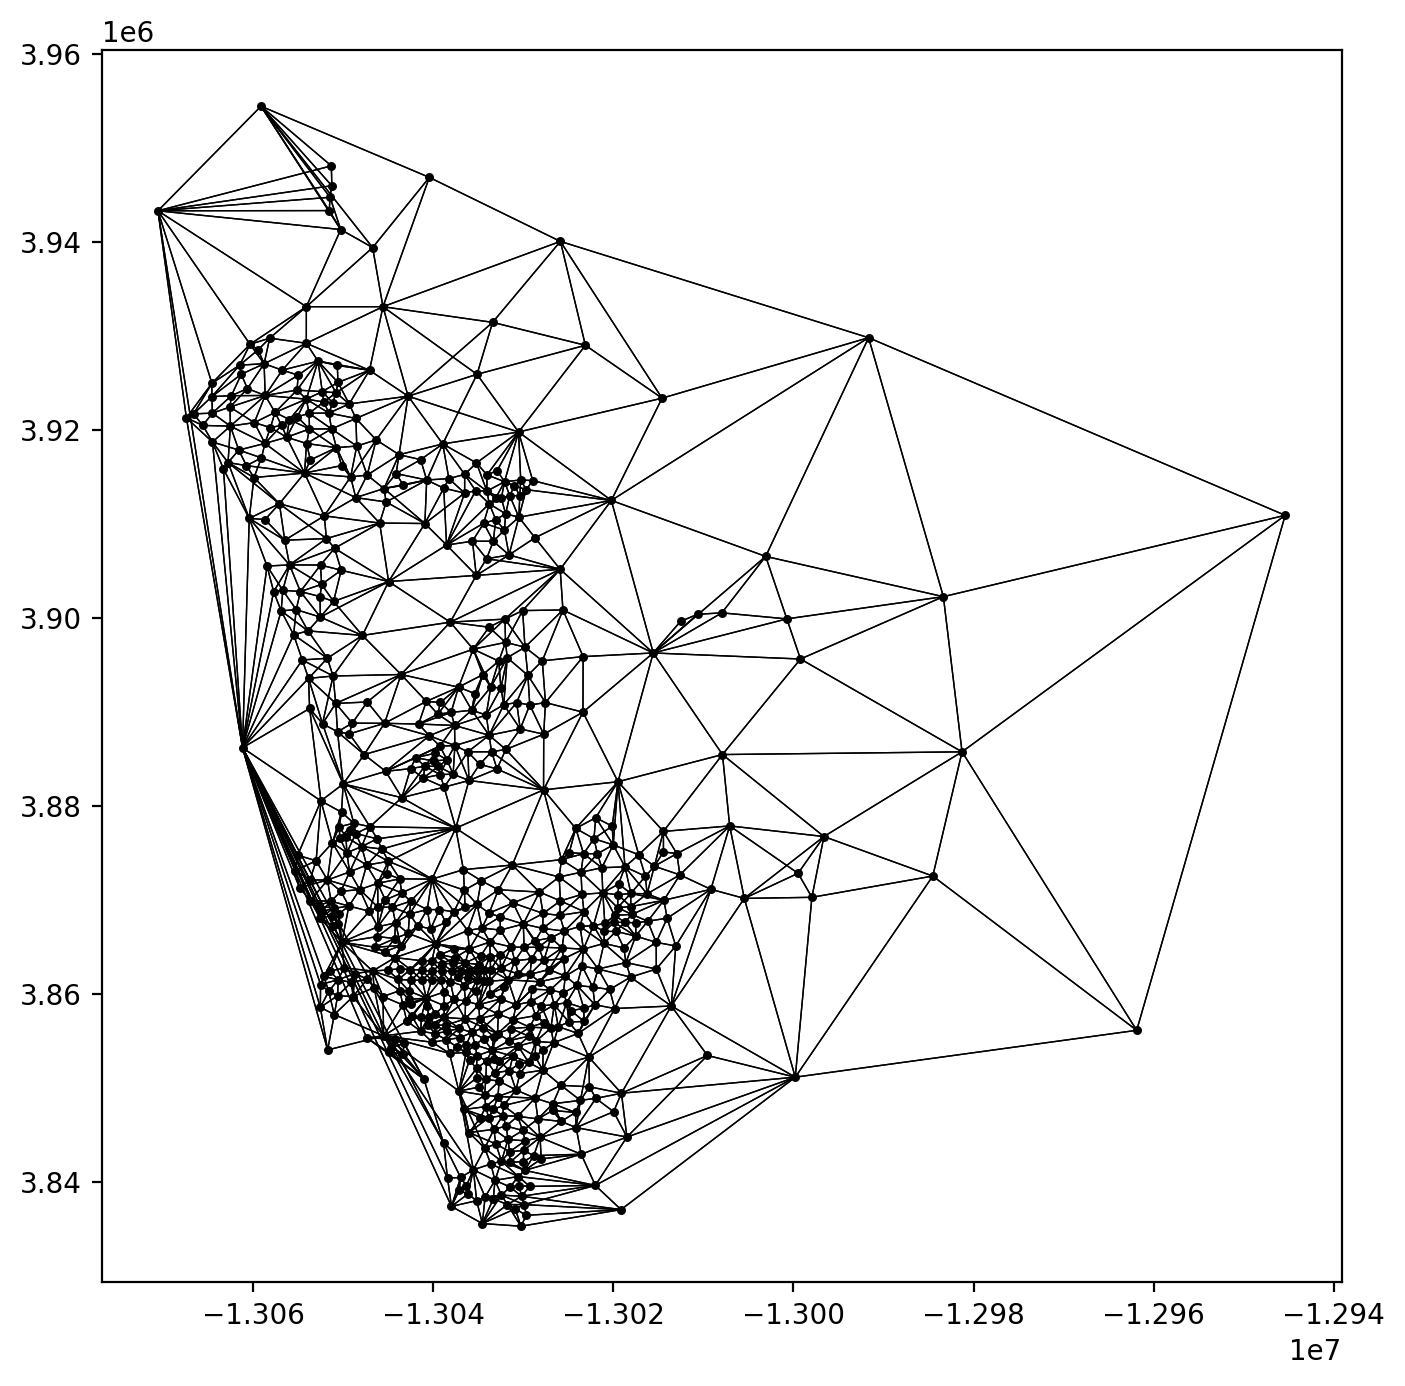

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
w_queen.plot(san_diego_tracts, ax=ax, edge_kws=dict(linewidth=0.5), node_kws=dict(s=5))

The weights object for San Diego tracts have the same attributes and methods as
we encountered with our artificial layout above:

In [21]:
print(w_queen.n)
print(w_queen.pct_nonzero)

628
1.018296888311899


First, we have a larger number of spatial units. The spatial weights are
also much sparser for the tracts than what we saw for our smaller toy
grid. Moreover, the cardinalities have a radically different distribution:

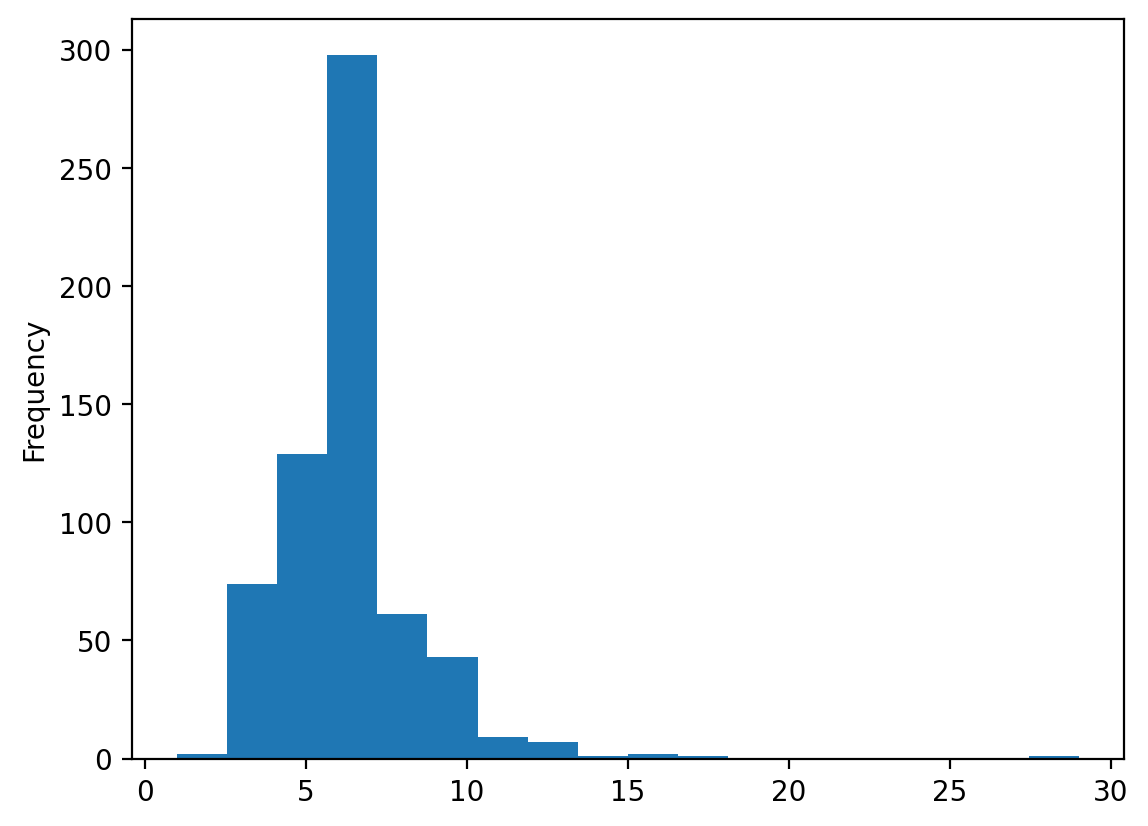

In [22]:
s = pandas.Series(w_queen.cardinalities)
s.plot.hist(bins=s.unique().shape[0]);

As the minimum number of neighbors is 1, while there is one polygon with 29
Queen neighbors. The most common number of neighbors is 6. For comparison, we
can also plot the equivalent for Rook weights of the same dataframe:

0.8722463385938578


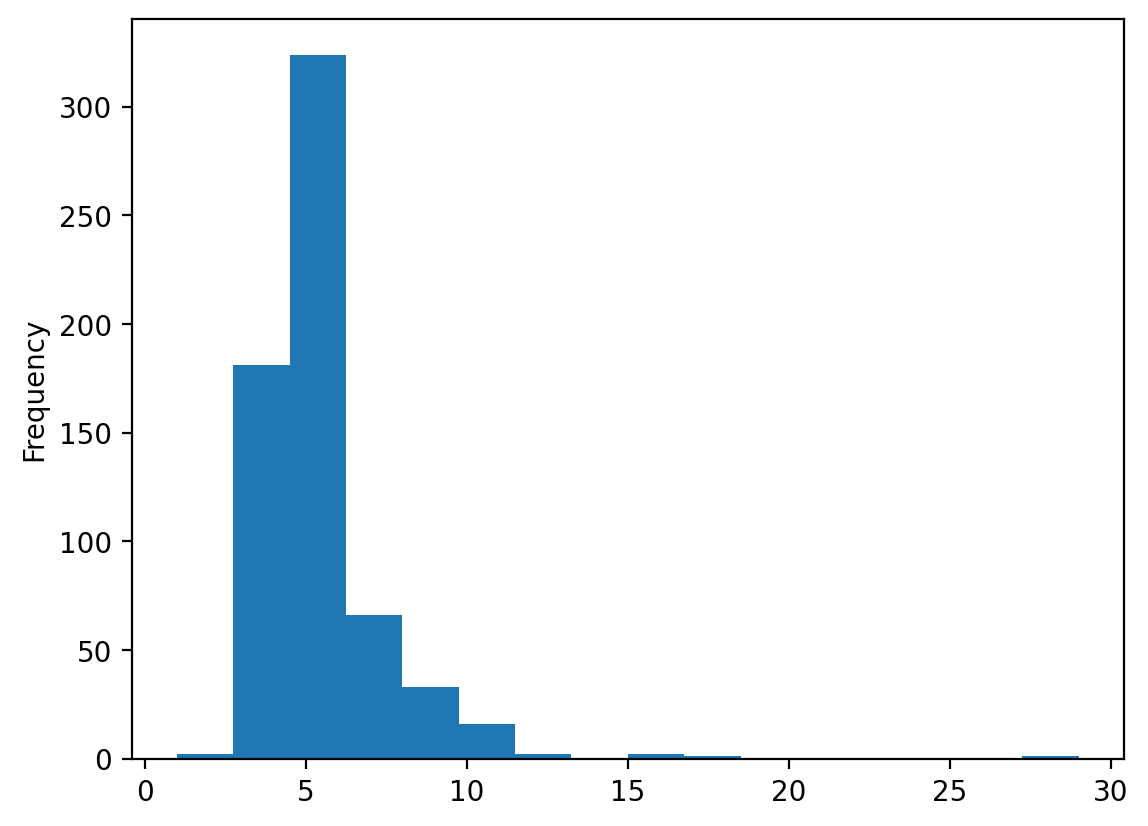

In [23]:
w_rook = weights.contiguity.Rook.from_dataframe(san_diego_tracts, use_index=True)
print(w_rook.pct_nonzero)
s = pandas.Series(w_rook.cardinalities)
s.plot.hist(bins=s.unique().shape[0]);

The cardinality histogram shifts downward due to the increasing sparsity of the
weights for the rook case relative to the Queen criterion. Conceptually, this makes sense: all Rook neighbors are also Queen neighbors, since Queen includes neighbors that share an edge; but, not all Queen neighbors are Rook neighbors, since some Queen neighbors only share a point on their boundaries in common. 

The example above shows how the notion of contiguity, although more
straightforward in the case of a grid, can be naturally extended beyond the
particular case of a regular lattice. The principle to keep in mind is that we
consider contiguous (and hence call neighbors) observations which share part
of their border coordinates. In the Queen case, a single point is enough to make
the join. For Rook neighbors, we require a join to consist of one or more
shared edges. This distinction is less relevant in the real world than
it appears in the grid example above. In any case, there are some cases
where this distinction can matter and it is useful to be familiar with the
differences between the two approaches. 

### Spatial weights from surfaces

Most often, we will use spatial weights as a way to connect features stored in rows of a geographic table. A more niche application is spatial weights derived from surfaces. Recalling from [Chapter 1](01_geo_thinking), the boundary between which phenomena get stored as tables and which ones as surfaces is blurring. This means that analytics that were traditionally developed for tables are increasingly being used on surfaces. Here, we illustrate how one can build spatial weights from data stored in surfaces. As we will see later in the book, this widens the range of analytics that we can apply to surface data.

For the illustration, we will use a surface that contains population counts for the Sao Paulo region in Brazil:

In [24]:
sao_paulo = rioxarray.open_rasterio("data/ghsl/ghsl_sao_paulo.tif")

From version 2.4 onwards, `pysal` added support to build spatial weights from `xarray.DataArray` objects.

In [25]:
w_sao_paulo = weights.contiguity.Queen.from_xarray(sao_paulo)

Although the internals differ quite a bit, once built, the objects are a sparse version of the same object that is constructed from a geographic table. 

In [26]:
w_sao_paulo

## Distance based weights

In addition to contiguity, we can also define neighbor relations as a function of
the distance separating spatial observations. Usually, this means that a matrix expressing the distances between all pairs of observations are required. These are then provided to a **kernel** function which uses the proximity information to model proximity as a smooth function of distance. `pysal` implements a family of
distance functions. Here we illustrate a selection beginning with the notion
of *nearest neighbor* weights.

### K-nearest neighbor weights

The first type of distance based weights defines the neighbor set of a
particular observation as containing its nearest $k$ observations, where the
user specifies the value of $k$. To illustrate this for the San Diego
tracts, we take $k=4$. This still leaves the issue of how to measure the distance
between these polygon objects, however. To do so we develop a representative
point for each of the polygons using the centroid. 

In [27]:
wk4 = weights.distance.KNN.from_dataframe(san_diego_tracts, k=4)

The centroids are calculated from
the spatial information stored in the `GeoDataFrame` as we have seen before. Since we are dealing with
polygons in this case, `pysal` uses inter-centroid distances to determine the
$k$ nearest observations to each polygon. 

The k-nearest neighbor weights displays no island problem, that is *everyone* has at least one neighbor:

In [28]:
wk4.islands

[]

This is the same for the contiguity case above but, in the case of k-nearest neighbor weights, this is by construction. Examination of the cardinality histogram for the k-nearest neighbor weights shows another built-in feature:

In [29]:
wk4.histogram

[(np.int64(4), np.int64(628))]

Everyone has the same number of neighbors. In some cases, this is not an issue but a desired feature. In
other contexts, however, this characteristic of k-nearest neighbor weights can be undesirable.
In such situations, we can turn to other types of distance-based weights.

### Kernel weights

The k-nearest neighbor rule assigns binary values to the weights for neighboring observations.
`pysal` also supports continuously valued weights to reflect Tobler's first law
{cite}`Tobler1970computer` in a more direct way: observations that are close to a unit have larger
weights than more distant observations.

Kernel weights are one of the most commonly-used kinds of distance weights. They
reflect the case where similarity/spatial proximity is assumed or expected to
decay with distance. The essence of kernel weights is that the weight between
observations $i$ and $j$ is based on their distance, but it is further modulated by
a kernel function with certain properties. `pysal` implements several kernels.
All of them share the properties of distance decay (thus encoding Tobler's First 
Law), but may decay at different rates with respect to distance.

As a computational note, it is worth mentioning that many of these distance-based decay functions require more resources than the contiguity weights or K-nearest neighbor weights discussed above. This is because the contiguity and k-nearest neighbor structures embed simple assumptions about how shapes relate in space, while kernel functions relax several of those assumptions. Thus, they provide more flexibility at the expense of computation.

The simplest way to compute Kernel weights in `pysal` involves a single function
call:

In [30]:
w_kernel = weights.distance.Kernel.from_dataframe(gdf)

Like k-nearest neighbor weights, the Kernel weights are based on distances between observations. By default, if the input data is an areal unit, we use a central representative point (like the centroid) for that polygon.
The value of the weights will be a function of two main options for
kernel weights: choice of kernel function and bandwidth. The
former controls how distance between $i$ and $j$ is "modulated" to produce 
the weight that goes in $w_{ij}$. In this respect, `pysal` offers a large number
of functions that determine the shape of the distance
decay function. The bandwidth specifies the distance from each focal unit over which
the kernel function is applied. For observations separated by distances larger
than the bandwidth, the weights are set to zero.

The default values for kernels are to use a triangular kernel with a bandwidth distance
equal to the maximum knn=2 distance
for all observations. The latter implies a so-called fixed bandwidth where all
observations use the same distance for the cut-off. We can inspect this from
the generated `W` object:

In [31]:
w_kernel.function

'triangular'

for the kernel function, and:

In [32]:
# Show the first five values of bandwidths
w_kernel.bandwidth[0:5]

array([[1.0000001],
       [1.0000001],
       [1.0000001],
       [1.0000001],
       [1.0000001]])

For the bandwidth applied to each observation.

Although simple, a fixed bandwidth is not always the best choice. For example,
in cases where the density of the observations varies over the study region,
using the same threshold anywhere will result in regions with a high density
of neighbors while others with observations very sparsely connected. In these
situations, an *adaptive* bandwidth -one which varies by observation and its
characteristics- can be preferred. 

Adaptive bandwidths are picked again using a K-nearest neighbor rule. A bandwidth for each observation is chosen such that, once the $k$-nearest observation is considered, all the remaining observations have zero weight. To illustrate it, we will use a subset of tracts in our San Diego dataset. First, visualizing the centroids, we can see that they are not exactly regularly-spaced, although others do nearly fall into a regular spacing:

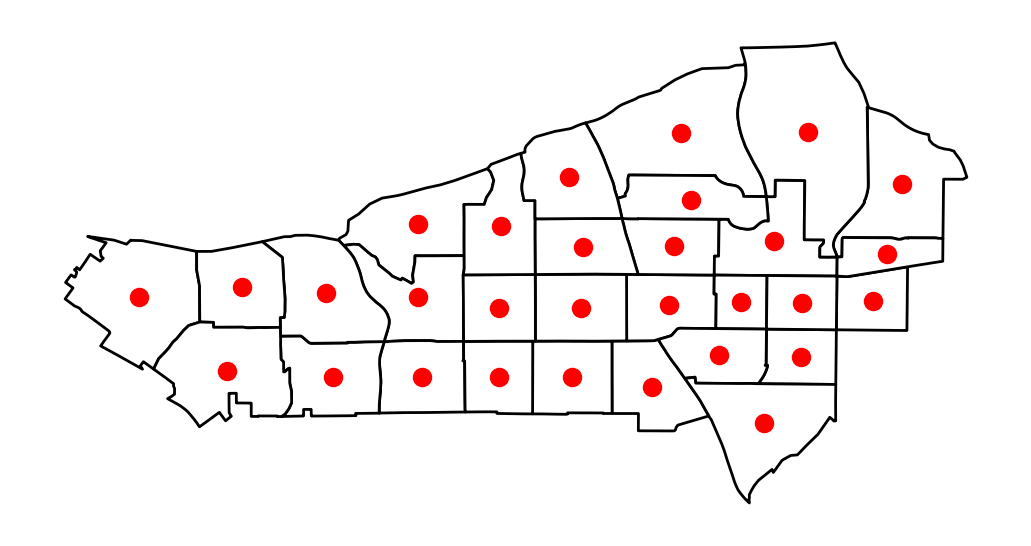

In [33]:
# Create subset of tracts
sub_30 = san_diego_tracts.query("sub_30 == True")
# Plot polygons
ax = sub_30.plot(facecolor="w", edgecolor="k")
# Create and plot centroids
sub_30.head(30).centroid.plot(color="r", ax=ax)
# Remove axis
ax.set_axis_off();

If we now build a weights object with adaptive bandwidth (`fixed=False`), the values for bandwidth differ:

In [34]:
# Build weights with adaptive bandwidth
w_adaptive = weights.distance.Kernel.from_dataframe(
    sub_30, fixed=False, k=15
)
# Print first five bandwidth values
w_adaptive.bandwidth[:5]

array([[7065.74020822],
       [3577.22591841],
       [2989.74807871],
       [2891.46196945],
       [3965.08354232]])

And, we can visualize what these kernels look like on the map, too, by focusing on an individual unit and showing how the distance decay attenuates the weight by grabbing the corresponding row of the full kernel matrix:

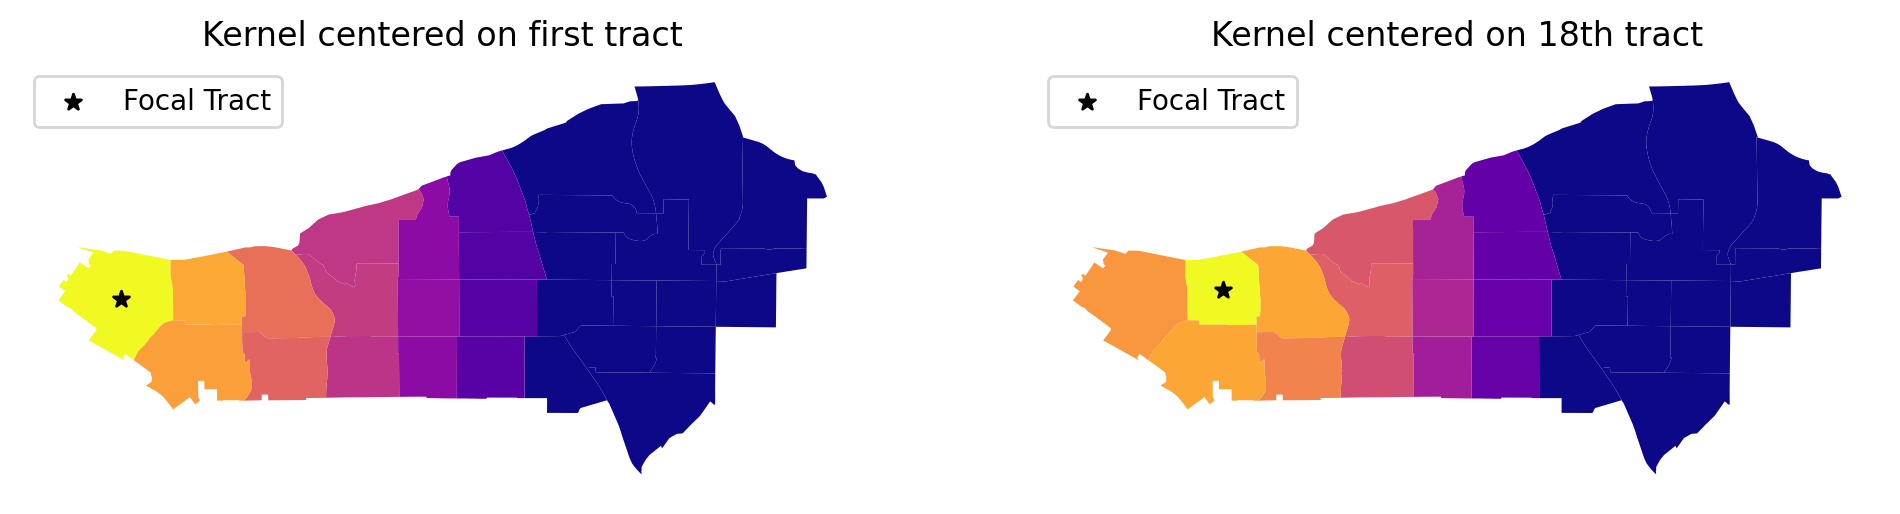

In [35]:
# Create full matrix version of weights
full_matrix, ids = w_adaptive.full()
# Set up figure with two subplots in a row
f, ax = plt.subplots(
    1, 2, figsize=(12, 6), subplot_kw=dict(aspect="equal")
)
# Append weights for first polygon and plot on first subplot
sub_30.assign(weight_0=full_matrix[0]).plot(
    "weight_0", cmap="plasma", ax=ax[0]
)
# Append weights for 18th polygon and plot on first subplot
sub_30.assign(weight_18=full_matrix[17]).plot(
    "weight_18", cmap="plasma", ax=ax[1]
)
# Add centroid of focal tracts
sub_30.iloc[[0], :].centroid.plot(
    ax=ax[0], marker="*", color="k", label="Focal Tract"
)
sub_30.iloc[[17], :].centroid.plot(
    ax=ax[1], marker="*", color="k", label="Focal Tract"
)
# Add titles
ax[0].set_title("Kernel centered on first tract")
ax[1].set_title("Kernel centered on 18th tract")
# Remove axis
[ax_.set_axis_off() for ax_ in ax]
# Add legend
[ax_.legend(loc="upper left") for ax_ in ax];

What the kernel looks like can be strongly affected by the structure of spatial proximity, so any part of the map can look quite different from any other part of the map. By imposing a clear distance decay over several of the neighbors of each observation,
kernel weights incorporate Tobler's law explicitly. Often, this comes at the cost of
increased memory requirements, as every single pair of observations within the
bandwidth distance is considered:

In [36]:
w_kernel.pct_nonzero

40.74074074074074

In many instances, this may be at odds with the nature of the spatial
interactions at hand, which operate over a more limited range of distance. In
these cases, expanding the neighborhood set beyond might lead us to consider
interactions which do not take place, or are inconsequential. Thus, for
both substantive and computational reasons, it might make sense to further
limit the range, keeping impacts hyper-local.

### Distance bands and hybrid Weights

In some contexts, it makes sense to draw a circle around each observation and
consider as neighbors every other observation that falls within the circle.
In the GIS terminology, this is akin to drawing a buffer around each point and
performing a point-in-polygon operation that determines whether the
other observations are within the buffer. If they are, they are assigned a
weight of one in the spatial weights matrix; if not they receive a zero.

In [37]:
w_bdb = weights.distance.DistanceBand.from_dataframe(
    gdf, 1.5, binary=True
)

This creates a binary distance weights where every other observation within
a distance of 1.5 is considered neighbor.

Distance band weights can also be continuously weighted. These could be seen as a kind of "censored" kernel, where the kernel function is applied only within a pre-specified distance. For example, let us calculate the DistanceBand weights that use inverse distance
weights up to a certain threshold and then truncate the weights to zero for
everyone else. For this example we will return to the small lattice example
covered in the beginning:

In [38]:
w_hy = weights.distance.DistanceBand.from_dataframe(
    gdf, 1.5, binary=False
)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/scipy/sparse/_data.py:128: RuntimeWarning: divide by zero encountered in power
  return self._with_data(data ** n)


We apply a threshold of 1.5 for this illustration. `pysal` truncates continuous
weights at this distance. It is important to keep in mind that the threshold
distance must use the same units of distance as the units used to define the
matrix.

To see the difference, consider polygon 4, in the middle of the grid. The Queen set of weights includes eight neighbors with a uniform weight of one:

In [39]:
wq.weights[4]

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

while the hybrid weights object modulates, giving less relevance to further observations (i.e., in this case those that only share a point):

In [40]:
w_hy.weights[4]

[0.7071067811865475,
 1.0,
 0.7071067811865475,
 1.0,
 1.0,
 0.7071067811865475,
 1.0,
 0.7071067811865475]

### Great circle distances

We must make one final curve before leaving the distance based weights. It is important that the
calculation of distances between objects takes the curvature of the Earth's
surface into account. This can be done before computing the spatial weights object, 
by transforming the coordinates of data points into a projected reference system. If 
this is not possible or convenient, an approximation that considers the
curvature implicit in non-projected reference systems (e.g.,
longitude/latitude) can be a sufficient workaround. `pysal` provides such
approximation as part of its functionality.

To illustrate the relevance of ignoring this aspect altogether, we will examine
distance based weights for the case of counties in the state of Texas. First, let us compute
a KNN-4 object that ignores the curvature of the Earth's surface (note how we use
in this case the `from_shapefile` constructor to build the weights directly from a
shapefile full of polygons):

In [41]:
# ignore curvature of the earth
knn4_bad = weights.distance.KNN.from_shapefile(
    "data/texas/texas.shp", k=4
)

Next, let us take curvature into account. To do this, we require the
radius of the Earth expressed in a given metric. `pysal` provides this number
in both miles and kilometers. For the sake of the example, we will use miles:

In [42]:
radius = geometry.sphere.RADIUS_EARTH_MILES
radius

3958.755865744055

With this measure at hand, we can pass it to the weights constructor (either
straight from a shapefile or from a `GeoDataFrame`), and distances will be
expressed in the units we have used for the radius, that is in miles in our
case:

In [43]:
knn4 = weights.distance.KNN.from_shapefile(
    "data/texas/texas.shp", k=4, radius=radius
)

Comparing the resulting neighbor sets, we see that ignoring the curvature of the
Earth's surface can create erroneous neighbor pairs. For example, the four *correct* nearest neighbors to observation 0 when accounting for the Earth's curvature are 6, 4, 5, and 3. However, observation 13 is *ever so slightly* closer when computing the straight line distance instead of the distance that accounts for curvature. 

In [44]:
knn4[0]

{np.int64(6): 1.0, np.int64(4): 1.0, np.int64(5): 1.0, np.int64(3): 1.0}

In [45]:
knn4_bad[0]

{np.int64(6): 1.0, np.int64(4): 1.0, np.int64(5): 1.0, np.int64(13): 1.0}

## Block weights 

A final type of spatial weight we examine here is block weights. In this case, 
it is membership in a geographic
 group that defines the neighbor relationships. Block weights connect every
observation in a dataset that belongs to the same category in a provided list.[^regions]
In essence, a block weight structure groups
individual observations and considers all members of the group as "near" one another. This means that they then have a value of one for every pair of observations in the same group. Contrariwise, all members *not* in that group are considered disconnected from any observation within the group, and given a value of zero. 
This is done for every group, so the resulting matrix looks like "blocks" of 1s stacked on the diagonal (assuming that observations in the same group are near one another in the input data table), hence the "block" weights. 

To demonstrate this class of spatial weights, we will use the tract dataset for
San Diego and focus on their county membership:

In [46]:
san_diego_tracts[["GEOID", "state", "county", "tract"]].head()

,GEOID,state,county,tract
0,06073018300,06,073,018300
1,06073018601,06,073,018601
2,06073017601,06,073,017601
3,06073019301,06,073,019301
4,06073018700,06,073,018700


Every tract has a unique ID (`GEOID`) and a county ID, shared by all tracts in
the same county. Since the entire region of San Diego is in California, the
state ID is the same across the dataset.

To build a block weights object, we do not even need spatial data beyond the
list of memberships. In this case, we will use the county membership:

In [47]:
# NOTE: since this is a large dataset, it might take a while to process
w_bl = weights.util.block_weights(
    san_diego_tracts["county"].values,
    ids=san_diego_tracts["GEOID"].values,
)

As a check, let's consider the first two rows in the table above. If the block
weights command has worked out correctly, both should be neighbors:

In [48]:
"06073000201" in w_bl["06073000100"]

True

We can use block weights as an intermediate step in more involved analyses
of "hybrid" spatial relationships. Suppose, for example, the researcher wanted to allow for
Queen neighbors within counties but not for tracts across different counties.
In this case, tracts from different counties would not be considered neighbors. To create such
as spatial weights matrix would require a combination of the Queen and the block
criteria, and `pysal` can implement that blending through one of the set operations shown in the next section.

## Set operations on weights

So far, we have seen different principles that guide how to build spatial
weights matrices. In this section, we explore how we can create new matrices
by *combining* different existing ones. This is useful in contexts where a
single neighborhood rule is inapt or when guiding principles
point to combinations of criteria.

We will explore these ideas in the section by returning to the San Diego tracts.
A number of ways exist to expand the basic criteria we have reviewed above and create
hybrid weights. In this example, we will generate a combination of the original contiguity
weights and the nearest neighbor weights. We will examine two different
approaches that provide similar solutions, thus illustrating the value of set
operations in `pysal`.



### Editing/connecting disconnected observations

Imagine one of our tracts was an island and did not have any neighbors in the contiguity case. This can
create issues in the spatial analytics that build on spatial weights, so it is good practice
to amend the matrix before using it.
The first approach we adopt is to find the nearest neighbor for the island observation
and then add this pair of neighbors to extend the neighbor pairs from the
original contiguity weight to obtain a fully connected set of weights. 

We will assume, for the sake of the example, that the disconnected observation was number 103. For us to reattach this tract, we can assign it to be "connected" to its nearest neighbor. Let's first extract our "problem" geometry:

In [49]:
disconnected_tract = san_diego_tracts.iloc[[103]]

As we have seen above, this tract *does* have neighbors:

In [50]:
w_queen[103]

{160: 1.0, 480: 1.0, 98: 1.0, 324: 1.0, 102: 1.0, 107: 1.0, 173: 1.0}

But, for this example, we will assume it does not and thus we find ourselves in the position of having to create additional neighboring units. This approach does not only apply in the context of islands. Sometimes, the process we are interested in may require that we manually edit the weights to better reflect connections we want to capture.

We will connect the observation to its nearest neighbor. To do this, we can construct the KNN graph as we did above, but set `k=1`, so observations are only assigned to their nearest neighbor:

In [51]:
wk1 = weights.distance.KNN.from_dataframe(san_diego_tracts, k=1)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 153 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


In this graph, all our observations are connected to one other observation by construction:

In [52]:
wk1.histogram

[(np.int64(1), np.int64(628))]

So is, of course, our tract of interest:

In [53]:
wk1.neighbors[103]

[np.int64(102)]

To connect it in our initial matrix, we need to create a copy of the `neighbors` dictionary and update the entry for `103`, including `102` as a neighbor. We copy the neighbors:

In [54]:
neighbors = w_rook.neighbors.copy()

and then we change the entry for the island observation to include its
nearest neighbor (`102`) as well as update `102` to have `103` as a neighbor:

In [55]:
neighbors[103].append(102)
neighbors[102].append(103)
w_new = weights.W(neighbors)
w_new[103]

{480: 1.0, 160: 1.0, 324: 1.0, 102: 1.0, 107: 1.0, 173: 1.0}

### Using the `union` of matrices

A more elegant approach to the island problem makes use of `pysal`'s support for
*set theoretic operations* on `pysal` weights. For example, we can construct the *union* of two weighting schemes, connecting any pair of observations if they are connected in *either* the Rook or if they are nearest neighbors:

In [56]:
w_fixed_sets = weights.set_operations.w_union(w_rook, wk1)

It is important to mention that this approach is not exactly the same, at least
in principle, as the one above. It could be that the nearest
observation was not originally a Rook neighbor and, in this case, the resulting
matrices would differ. This is a rare but theoretically possible situation.

## Visualizing weight set operations

To further build the intuition behind different criteria, in this section 
we illustrate these concepts using the 32 states of Mexico. 
We compare the neighbor graphs that results from some of the 
criteria introduced to define neighbor relations. We first read in the data for Mexico:

In [57]:
mx = geopandas.read_file("data/mexico/mexicojoin.shp")

We will contrast the look of the connectivity graphs built following several criteria; so, to streamline things, let's build the weights objects first:

- Queen contiguity

In [58]:
mx_queen = weights.contiguity.Queen.from_dataframe(mx)

/var/folders/dy/m471zxc92yg3d_nmckq9dd000000gn/T/ipykernel_58063/2535527868.py:1: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  mx_queen = weights.contiguity.Queen.from_dataframe(mx)


- $K$-NN with four nearest neighbors

In [59]:
mx_knn4 = weights.KNN.from_dataframe(mx, k=4)

- Block weights at the federal region level

In [60]:
mx_bw = weights.util.block_weights(mx["INEGI2"].values)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/libpysal/weights/util.py:296: UserWarning: The weights matrix is not fully connected: 
 There are 5 disconnected components.
  w = W(neighbors, **kwargs)


- A combination of block and Queen that connects contiguous neighbors _across_ regions

In [61]:
mx_union = weights.set_operations.w_union(mx_bw, mx_queen)

With these at hand, we will build a figure that shows the connectivity graph of each weights object. For cases where the federal regions are used to define blocks, we will color states based on the region they belong to.

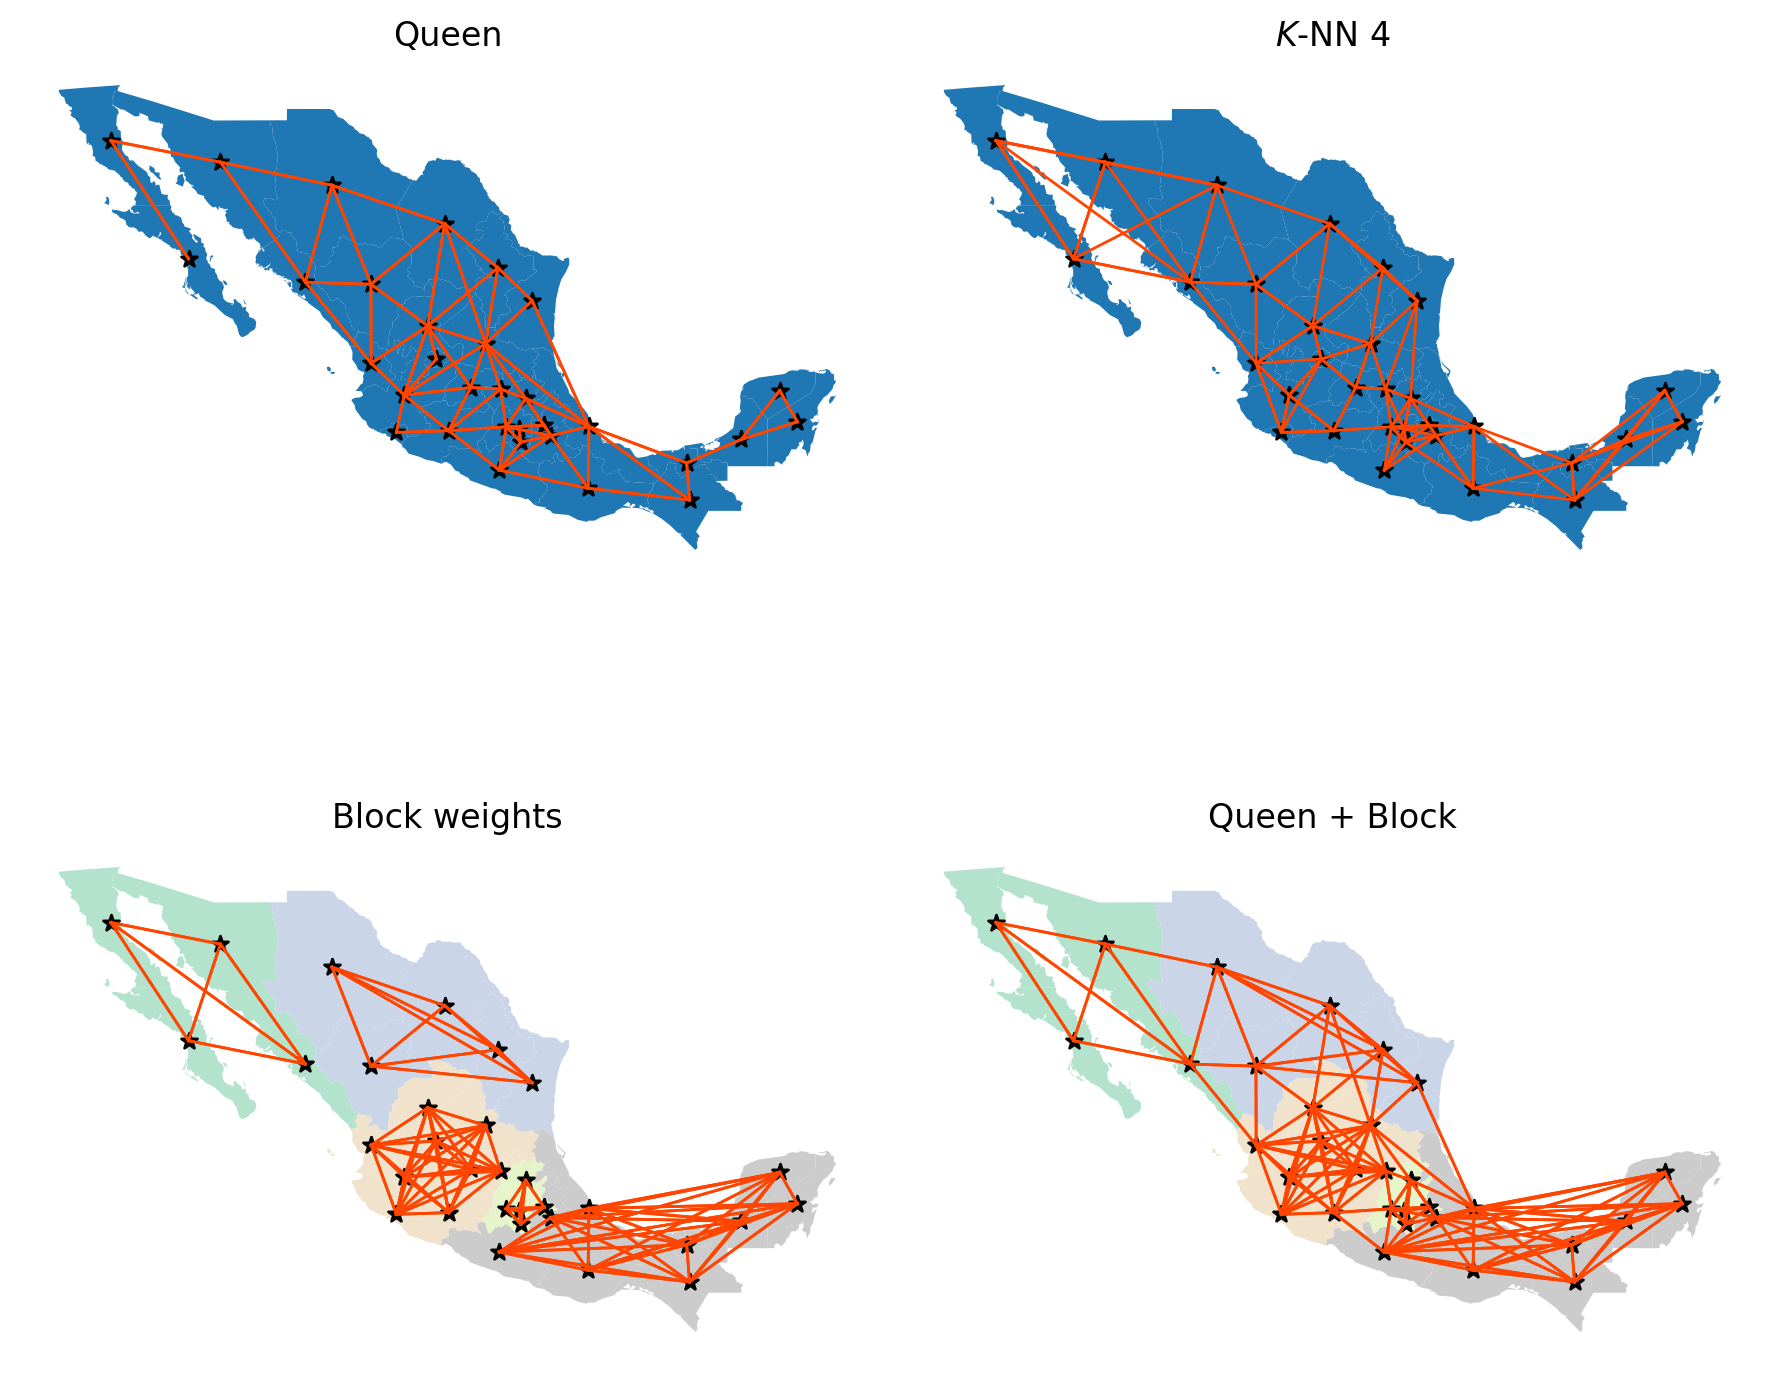

In [62]:
# Set up figure and axis
f, axs = plt.subplots(2, 2, figsize=(9, 9))

# Contiguity
ax = axs[0, 0]
mx.plot(ax=ax)
mx_queen.plot(
    mx,
    edge_kws=dict(linewidth=1, color="orangered"),
    node_kws=dict(marker="*"),
    ax=ax,
)
ax.set_axis_off()
ax.set_title("Queen")

# KNN
ax = axs[0, 1]
mx.plot(ax=ax)
mx_knn4.plot(
    mx,
    edge_kws=dict(linewidth=1, color="orangered"),
    node_kws=dict(marker="*"),
    ax=ax,
)
ax.set_axis_off()
ax.set_title("$K$-NN 4")

# Block
ax = axs[1, 0]
mx.plot(column="INEGI2", categorical=True, cmap="Pastel2", ax=ax)
mx_bw.plot(
    mx,
    edge_kws=dict(linewidth=1, color="orangered"),
    node_kws=dict(marker="*"),
    ax=ax,
)
ax.set_axis_off()
ax.set_title("Block weights")

# Union
ax = axs[1, 1]
mx.plot(column="INEGI2", categorical=True, cmap="Pastel2", ax=ax)
mx_union.plot(
    mx,
    edge_kws=dict(linewidth=1, color="orangered"),
    node_kws=dict(marker="*"),
    ax=ax,
)
ax.set_axis_off()
ax.set_title("Queen + Block")
f.tight_layout()
plt.show()

Queen and KNN graphs are relatively similar but, as one would expect, the KNN is sparser than Queen in areas with high density of irregular polygons (Queen will connect each to more than four), and denser in sparser areas with less but larger polygons (e.g., northwest). Focusing on the Queen and Block graphs, there are clear distinctions between the
connectivity structures. The Block graph is visually denser in particular areas relative to the
Queen graph, and this is captured in their sparsity measures:

In [63]:
mx_bw.pct_nonzero

19.140625

In [64]:
mx_queen.pct_nonzero

13.4765625

The other distinguishing characteristic can be seen in the number of connected
components in the different graphs. The Queen graph has a single connected
component, which in graph theory terms, means for all pairs of states there is
at least one path of edges that connects the two states. The Block graph has
five connected components, one for each of the five regions. Moreover, each of
these connected components is fully-connected, meaning there is an edge that
directly connects each pair of member states. However, there are no edges
between states belonging to different blocks (or components).


As we will see in later chapters, certain spatial analytical techniques require
a fully connected weights graph. In these cases, we could adopt the Queen
definition since this satisfies the single connected component requirement.
However, we may wish to use the Union weights graph, as that provides a single
connected component, but offers a blend of different types of connectivity
intensities, with the intra-regional (block) linkages being very dense, while
the inter-regional linkages are thinner but provide for the single connected
component.

## Use case: boundary detection

We close the chapter with an illustration of how weights can be useful by themselves in geographic data science. Note that the application displayed below involves some concepts and code that are a bit more advanced than in the rest of the chapter. If you are up for the challenge, we think the insights it enables are worth the effort!

Spatial weights are ubiquitous in the analysis of spatial patterns in data, since they provide a direct method to represent spatial structure. 
However, spatial weights are also useful in their own right, such as when examining latent structures directly in the graphs themselves or when using them to conduct descriptive analysis. 
One clear use case that arises in the analysis of social data is to characterize latent *data discontinuities*. By *data discontinuity*, we mean a single border (or collection of borders) where data for a variable (or many variables) of interest change abruptly. 
These can be used in models of inequality {cite}`Lu2005bayesian,Fitzpatrick2010ecological,Dean2019frontiers` or used to adapt classic empirical outlier detection methods. 
Below, we'll show one model-free way to identify empirical boundaries in your data. 

First, let's consider the median household income for our census tracts in San Diego, shown in the following figure.

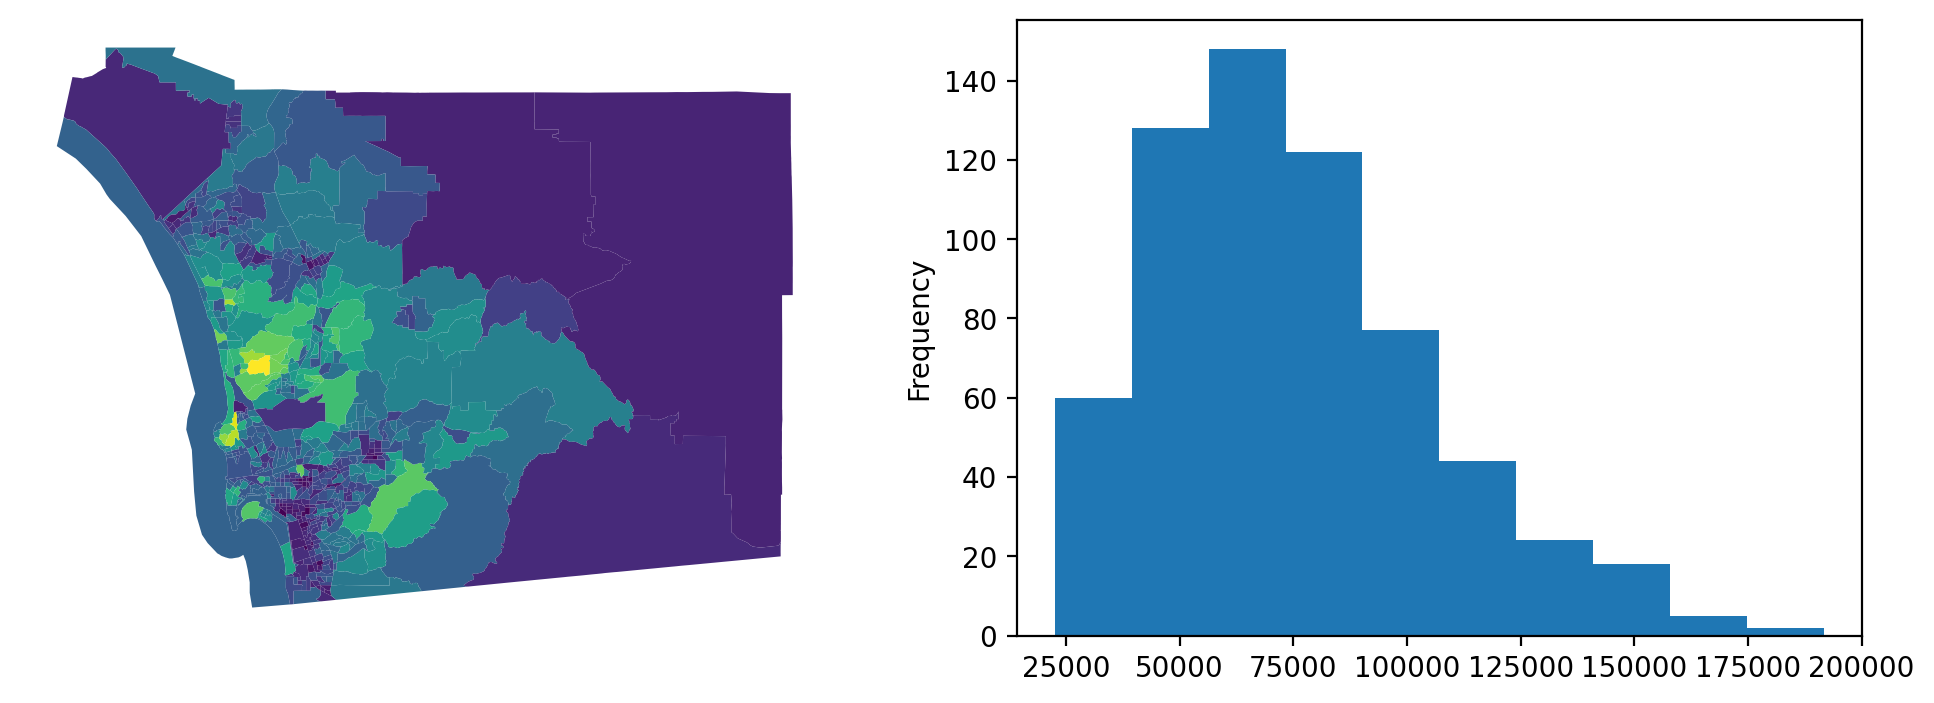

In [65]:
f, ax = plt.subplots(1, 2, figsize=(12, 4))
san_diego_tracts.plot("median_hh_income", ax=ax[0])
ax[0].set_axis_off()
san_diego_tracts["median_hh_income"].plot.hist(ax=ax[1])
plt.show()

Now, we see some cases where there are very stark differences between neighboring areas, and some cases where there appear to be no difference between adjacent areas. Digging into this, we can examine the *distribution of differences* in neighboring areas using the adjacency list, a different representation of a spatial graph:

In [66]:
adjlist = w_rook.to_adjlist(drop_islands=True)
adjlist.head()

,focal,neighbor,weight
0,0,1,1.0
1,0,4,1.0
2,0,27,1.0
3,0,383,1.0
4,0,385,1.0


This provides us with a table featuring three columns. `Focal` is the column containing the "origin" of the link, `neighbor` is the column containing the "destination" of the link, or neighbor of the focal polygon, and `weight` contains how strong the link from `focal` to `neighbor` is. Since our weights are *symmetrical*, this table contains two entries per pair of neighbors, one for `(focal,neighbor)` and the other for `(neighbor,focal)`. 

Now we want to connect this table representing spatial structure with information on median household income. Using `pandas`, we can merge up the focal units' and neighboring units' median household incomes:

In [67]:
adjlist_income = adjlist.merge(
    san_diego_tracts[["median_hh_income"]],
    how="left",
    left_on="focal",
    right_index=True,
).merge(
    san_diego_tracts[["median_hh_income"]],
    how="left",
    left_on="neighbor",
    right_index=True,
    suffixes=("_focal", "_neighbor"),
)
adjlist_income.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3440 entries, 0 to 3439
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   focal                      3440 non-null   int64  
 1   neighbor                   3440 non-null   int64  
 2   weight                     3440 non-null   float64
 3   median_hh_income_focal     3440 non-null   float64
 4   median_hh_income_neighbor  3440 non-null   float64
dtypes: float64(3), int64(2)
memory usage: 134.5 KB


This operation brings together the income at both the focal observation and the neighbor observation. The difference between these two yields income differences between *adjacent* tracts:

In [68]:
adjlist_income["diff"] = (
    adjlist_income["median_hh_income_focal"]
    - adjlist_income["median_hh_income_neighbor"]
)

With this information on difference we can now do a few things. First, we can compare whether or not this *distribution* is distinct from the distribution of non-neighboring tracts' differences in wealth. This will give us a hint at the extent to which income follows a spatial pattern. This is also discussed more in depth in the spatial inequality chapter, specifically in reference to the Spatial Gini. 

To do this, we can first compute the all-pairs differences in income using the `numpy.subtract` function. Some functions in `numpy` have special functionality; these `ufuncs` (short for "universal functions") often support special applications to your data. Here, we will use `numpy.subtract.outer` to take the difference over the "outer Cartesian product" of two vectors.

In [69]:
all_pairs = numpy.subtract.outer(
    san_diego_tracts["median_hh_income"].values,
    san_diego_tracts["median_hh_income"].values,
)

In practice, this results in an $N\times N$ array that stores the subtraction of all  combinations of the input vectors.

Then, we need to filter out those cells of `all_pairs` that are neighbors. Fortunately, our weights matrix is *binary*. So, subtracting it from an $N \times N$ matrix of $1$s will result in the *complement* of our original weights matrix:

In [70]:
complement_wr = 1 - w_rook.sparse.toarray()

Note `complement_wr` inserts a 0 where `w_rook` includes a 1, and vice versa. Using this complement, we can filter the `all_pairs` matrix to only consider the differences in median household income for tracts that are not neighboring: 

In [71]:
non_neighboring_diffs = (complement_wr * all_pairs).flatten()

Now, we can compare the two distributions of the difference in wealth:

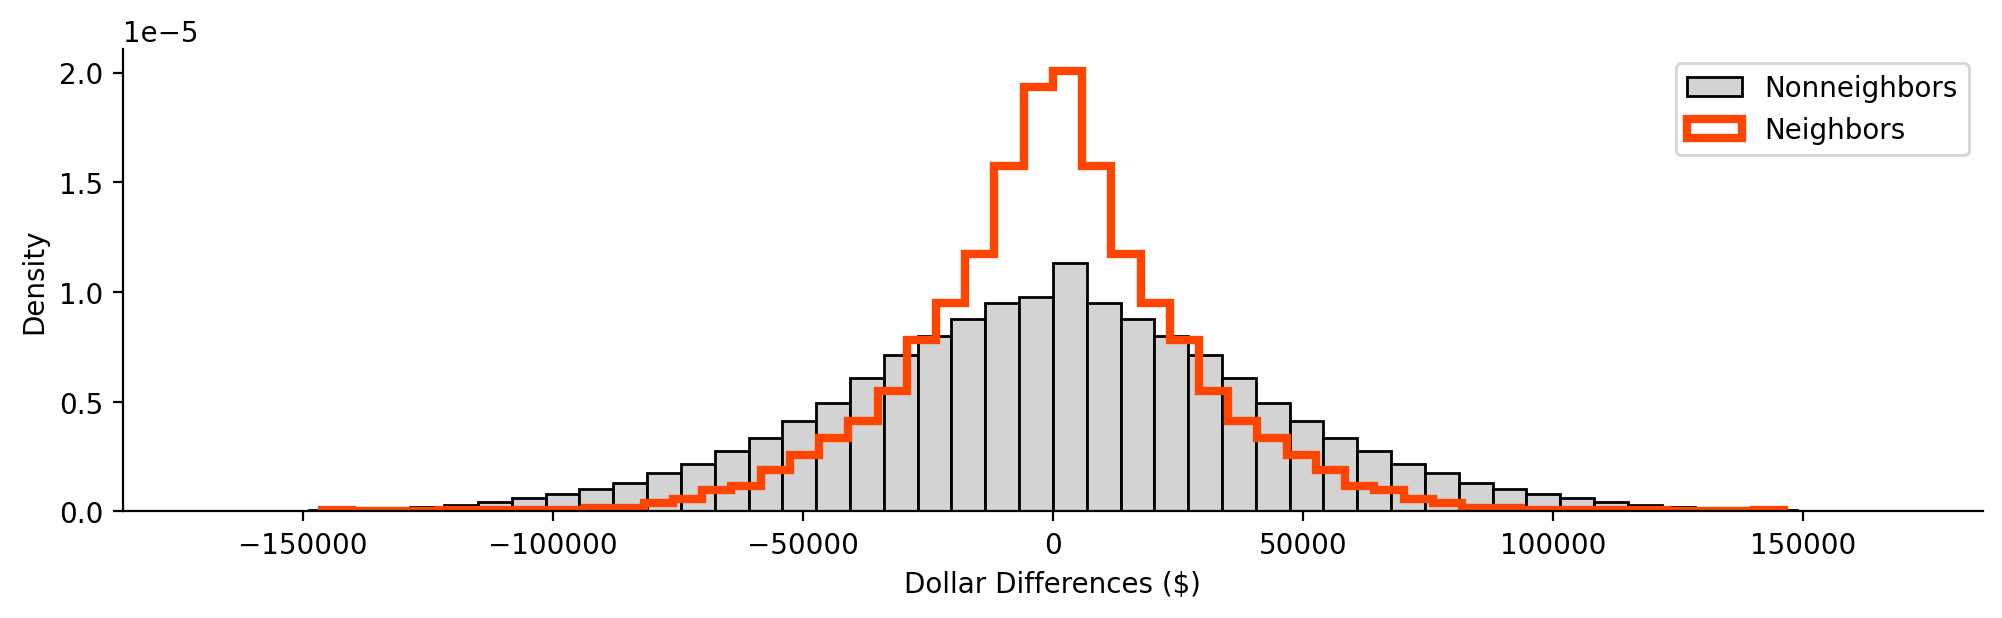

In [72]:
f = plt.figure(figsize=(12, 3))
plt.hist(
    non_neighboring_diffs,
    color="lightgrey",
    edgecolor="k",
    density=True,
    bins=50,
    label="Nonneighbors",
)
plt.hist(
    adjlist_income["diff"],
    color="salmon",
    edgecolor="orangered",
    linewidth=3,
    density=True,
    histtype="step",
    bins=50,
    label="Neighbors",
)
seaborn.despine()
plt.ylabel("Density")
plt.xlabel("Dollar Differences ($)")
plt.legend();

From this, we can see that the two distributions are distinct, with the distribution of difference in *non-neighboring* tracts being slightly more dispersed than that for *neighboring* tracts. Thus, on the whole, this means that neighboring tracts have more *smaller differences in wealth* than non-neighboring tracts. This is consistent with the behavior we will talk about in later chapters concerning *spatial autocorrelation*, the tendency for observations to be statistically more similar to nearby observations than they are to distant observations. 

The adjacency table we have built can also help us find our *most extreme* observed differences in income, hinting at possible hard boundaries between the areas. Since our links are symmetric, we can then focus only on focal observations with *the most extreme* difference in wealth from their immediate neighbors, considering only those where the *focal* is higher, since they each have an equivalent *negative* back-link.

In [73]:
extremes = adjlist_income.sort_values("diff", ascending=False).head()
extremes

,focal,neighbor,weight,median_hh_income_focal,median_hh_income_neighbor,diff
2606,473,163,1.0,183929.0,37863.0,146066.0
2605,473,157,1.0,183929.0,64688.0,119241.0
1890,343,510,1.0,151797.0,38125.0,113672.0
2607,473,238,1.0,183929.0,74485.0,109444.0
51,8,89,1.0,169821.0,66563.0,103258.0


Thus, we see that observation $473$ appears often on  the `focal` side, suggesting it's quite distinct from its nearby polygons. 

To verify whether these differences are truly significant, we can use a map randomization strategy. In this case, we shuffle values across the map and compute *new* `diff` columns. This time, `diff` represents the difference between random incomes, rather than the neighboring incomes we actually observed using our Rook contiguity matrix. Using many `diff` vectors, we can find the observed differences which tend to be much larger than those encountered in randomly-drawn maps of household income.

To start, we can construct many random `diff` vectors:

In [74]:
## NOTE: this cell runs a simulation and may take a bit longer
## If you want it to run faster, decrease the number of shuffles
## by setting a lower value in `n_simulations`

# Set number or random shuffles
n_simulations = 1000
# Create an empty array to store results
simulated_diffs = numpy.empty((len(adjlist), n_simulations))
# Loop over each random draw
for i in range(n_simulations):
    # Extract income values
    median_hh_focal = adjlist_income["median_hh_income_focal"].values
    # Shuffle income values across locations
    random_income = (
        san_diego_tracts[["median_hh_income"]]
        .sample(frac=1, replace=False)
        .reset_index()
    )
    # Join income to adjacency
    adjlist_random_income = adjlist.merge(
        random_income, left_on="focal", right_index=True
    ).merge(
        random_income,
        left_on="neighbor",
        right_index=True,
        suffixes=("_focal", "_neighbor"),
    )
    # Store reslults from random draw
    simulated_diffs[:, i] = (
        adjlist_random_income["median_hh_income_focal"]
        - adjlist_random_income["median_hh_income_neighbor"]
    )

After running our simulation, we get many distributions of pairwise differences in household income. Below, we plot the shroud of all the simulated differences, shown in black, and our observed differences, shown in red:

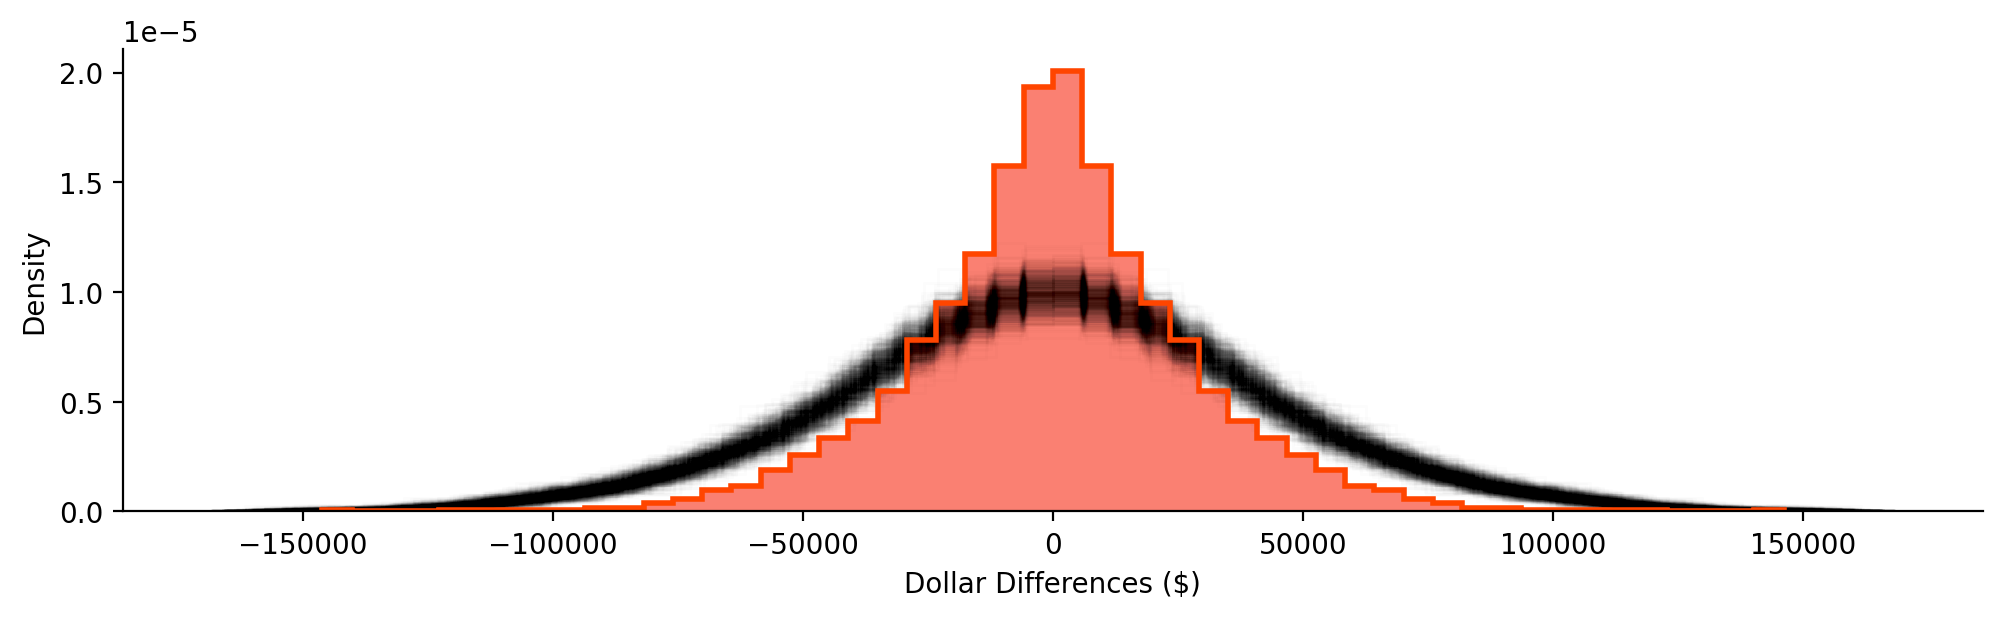

In [75]:
# Set up figure
f = plt.figure(figsize=(12, 3))
# Build background histogram for observed differences
plt.hist(
    adjlist_income["diff"],
    color="salmon",
    bins=50,
    density=True,
    alpha=1,
    linewidth=4,
)
# Plot simulated, random differences
[
    plt.hist(
        simulation,
        histtype="step",
        color="k",
        alpha=0.01,
        linewidth=1,
        bins=50,
        density=True,
    )
    for simulation in simulated_diffs.T
]
# Build histogram borderline for observed differences
plt.hist(
    adjlist_income["diff"],
    histtype="step",
    edgecolor="orangered",
    bins=50,
    density=True,
    linewidth=2,
)
# Style figure
seaborn.despine()
plt.ylabel("Density")
plt.xlabel("Dollar Differences ($)")
plt.show()

Again, our random distribution is much more dispersed than our observed distribution of the differences between nearby tracts. Empirically, we can pool our simulations and construct and use their quantiles to summarize how unlikely any of our *observed* differences are if neighbors' household incomes were randomly assigned:

In [76]:
simulated_diffs.flatten().shape

(3440000,)

In [77]:
# Convert all simulated differences into a single vector
pooled_diffs = simulated_diffs.flatten()
# Calculate the 0.5th, 50th and 99.5th percentiles
lower, median, upper = numpy.percentile(
    pooled_diffs, q=(0.5, 50, 99.5)
)
# Create a swith that is True if the value is "extreme"
# (in the 0.5th percentile or/`|` in the 00.5th), False otherwise
outside = (adjlist_income["diff"] < lower) | (
    adjlist_income["diff"] > upper
)

Despite the fact  that our observed differences are less dispersed on average, we can identify two boundaries in the data that are in the top 1% most extreme differences in neighboring household incomes across the map. These boundaries are shown in the table below:

In [78]:
adjlist_income[outside]

,focal,neighbor,weight,median_hh_income_focal,median_hh_income_neighbor,diff
888,157,473,1.0,64688.0,183929.0,-119241.0
916,163,473,1.0,37863.0,183929.0,-146066.0
2605,473,157,1.0,183929.0,64688.0,119241.0
2606,473,163,1.0,183929.0,37863.0,146066.0


Note that one of these, observation $473$, appears in both boundaries. This means that the observation is likely to be *outlying*, extremely unlike *all* of its neighbors. These kinds of generalized neighborhood comparisons are discussed in the subsequent chapter on local spatial autocorrelation. For now we can visualize this on a map, focusing on the two boundaries around observation $473$, shown also in the larger context of San Diego incomes:

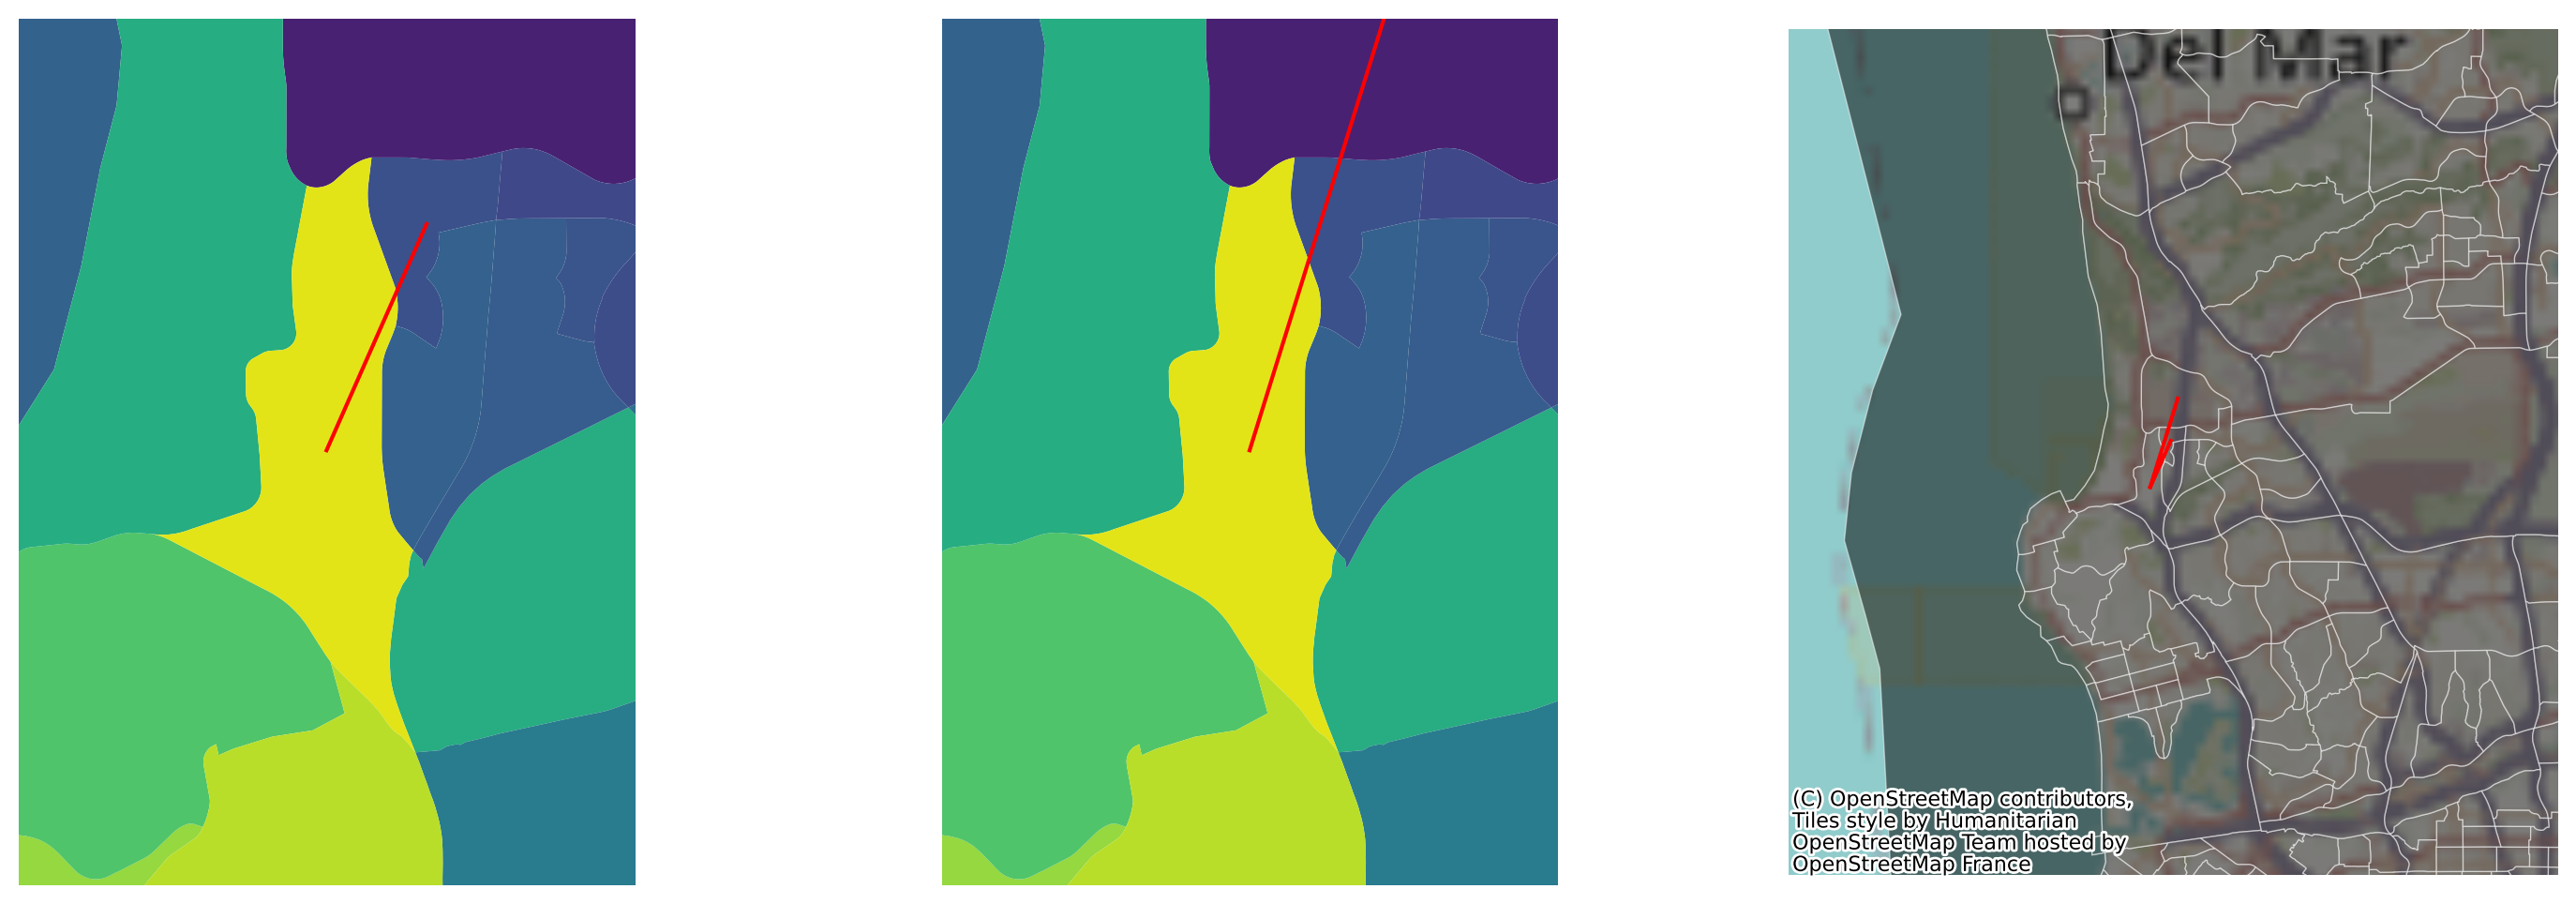

In [79]:
f, ax = plt.subplots(1, 3, figsize=(18, 6))

# Plot tracts
for i in range(2):
    san_diego_tracts.plot("median_hh_income", ax=ax[i])

# Zoom 1
first_focus = san_diego_tracts.iloc[[473, 157]]
ax[0].plot(
    first_focus.centroid.x, first_focus.centroid.y, color="red"
)
west, east, south, north = first_focus.buffer(1000).total_bounds
ax[0].axis([west, south, east, north])
ax[0].set_axis_off()

# Zoom 2
second_focus = san_diego_tracts.iloc[[473, 163]]
ax[1].plot(
    second_focus.centroid.x, second_focus.centroid.y, color="red"
)
ax[1].axis([west, south, east, north])
ax[1].set_axis_off()

# Context
san_diego_tracts.plot(
    facecolor="k", edgecolor="w", linewidth=0.5, alpha=0.5, ax=ax[2]
)
contextily.add_basemap(ax[2], crs=san_diego_tracts.crs)
area_of_focus = (
    pandas.concat((first_focus, second_focus))
    .buffer(12000)
    .total_bounds
)
ax[2].plot(
    first_focus.centroid.x, first_focus.centroid.y, color="red"
)
ax[2].plot(
    second_focus.centroid.x, second_focus.centroid.y, color="red"
)
west, east, south, north = area_of_focus
ax[2].axis([west, south, east, north])
ax[2].set_axis_off()

These are the starkest contrasts in the map, and result in the most distinctive divisions between adjacent tracts' household incomes. 

## Conclusion

Spatial weights are central to how we *represent* spatial relationships in mathematical and computational environments. At their core, they are a "geo-graph," or a network defined by the geographical relationships between observations. They form kind of a "spatial index," in that they record which observations have a specific geographical relationship. Since spatial weights are fundamental to how spatial relationships are represented in geographic data science, we will use them again and again throughout the book. 